In [ ]:
import sys
!{sys.executable} -m pip install matplotlib==3.1.0 seaborn==0.10.0 scikit-learn==0.22.1 numpy==1.18.1 pandas==0.25.3 py3Dmol prody==1.10.11 --user

# Classification

Classification, in the field of data science, typically refers to categorizing objects into a discrete set of groups. For example:
* Your email provider has an algorithm to "classify" emails as spam or not spam. 
* An OCR (automatic character recognition) algorithm can take an image of a hand-drawn character and decide which alphabet it represents.
* Some online newspapers can have algorithms to automatically place articles into different categories, like Politics, Sports, Literature etc.

There are many different kinds of algorithms that can perform classification, we'll look at two in this notebook.

## Imports and helper functions

Here we import some useful libraries and define some functions that we'll use later in the notebook. Make sure you run these cells before continuing. You don't have to understand the code though, it will become clear when we use them.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
RANDOM_STATE = 42

In [2]:
def plot_decision_boundary(X, y, feature_names, clf, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    # Plot the decision boundary by assigning a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[feature_names[0]].min() - 1, X[feature_names[0]].max() + 1
    y_min, y_max = X[feature_names[1]].min() - 1, X[feature_names[1]].max() + 1
    step = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    # Predict on all data points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.6, cmap="RdYlBu_r")
    # Plot data points
    sns.scatterplot(data=X, x=feature_names[0], y=feature_names[1], hue=y, s=30, palette="RdYlBu_r", ax=ax, edgecolor='black')

In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=14):
    """Plots a confusion matrix as a heatmap.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## The Iris Dataset

This is a very popular data set of Iris flower measurements. It consists of 50 samples or **data points** from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four attributes or **features** were measured from each data point: the length and the width of the sepals and petals, in centimeters. This dataset can be framed as a classification problem where the task is to categorize each data point into one of three classes - setosa, virginica, or versicolor.

In [4]:
iris_dataset = datasets.load_iris()
display(Markdown(iris_dataset.DESCR))

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
    :Class Distribution: 33.3% for each of 3 classes.
    :Creator: R.A. Fisher
    :Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
    :Date: July, 1988

The famous Iris database, first used by Sir R.A. Fisher. The dataset is taken
from Fisher's paper. Note that it's the same as in R, but not as in the UCI
Machine Learning Repository, which has two wrong data points.

This is perhaps the best known database to be found in the
pattern recognition literature.  Fisher's paper is a classic in the field and
is referenced frequently to this day.  (See Duda & Hart, for example.)  The
data set contains 3 classes of 50 instances each, where each class refers to a
type of iris plant.  One class is linearly separable from the other 2; the
latter are NOT linearly separable from each other.

.. topic:: References

   - Fisher, R.A. "The use of multiple measurements in taxonomic problems"
     Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to
     Mathematical Statistics" (John Wiley, NY, 1950).
   - Duda, R.O., & Hart, P.E. (1973) Pattern Classification and Scene Analysis.
     (Q327.D83) John Wiley & Sons.  ISBN 0-471-22361-1.  See page 218.
   - Dasarathy, B.V. (1980) "Nosing Around the Neighborhood: A New System
     Structure and Classification Rule for Recognition in Partially Exposed
     Environments".  IEEE Transactions on Pattern Analysis and Machine
     Intelligence, Vol. PAMI-2, No. 1, 67-71.
   - Gates, G.W. (1972) "The Reduced Nearest Neighbor Rule".  IEEE Transactions
     on Information Theory, May 1972, 431-433.
   - See also: 1988 MLC Proceedings, 54-64.  Cheeseman et al"s AUTOCLASS II
     conceptual clustering system finds 3 classes in the data.
   - Many, many more ...

We load the dataset into a DataFrame below, kind of like an Excel spreadsheet, and arbitrarily label setosa as class 0, versicolor as class 1, and virginica as class 2 (in the column species_index)

In [5]:
iris_dataframe = pd.DataFrame(iris_dataset.data,
                              columns=iris_dataset.feature_names)
iris_dataframe["species"] = [iris_dataset.target_names[t] for t in iris_dataset.target]
iris_dataframe["species_index"] = iris_dataset.target
iris_dataframe["species_index"] = iris_dataframe["species_index"].astype('category')
iris_dataframe.head(100) 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_index
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,versicolor,1
96,5.7,2.9,4.2,1.3,versicolor,1
97,6.2,2.9,4.3,1.3,versicolor,1
98,5.1,2.5,3.0,1.1,versicolor,1


To get a better understanding of the values in this dataset, let's take a look at the summary statistics of the different features:

In [6]:
iris_dataframe.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


To get a more visual overview of this dataset, we can plot histograms of each feature separately, and pair-plots of each pair of features. A pair-plot is a plot in which the X-axis coordinate represents one feature value and the Y-acis coordinate represents the second feature value. We also color each point by its species, to see how different features correlate with the species categorization.

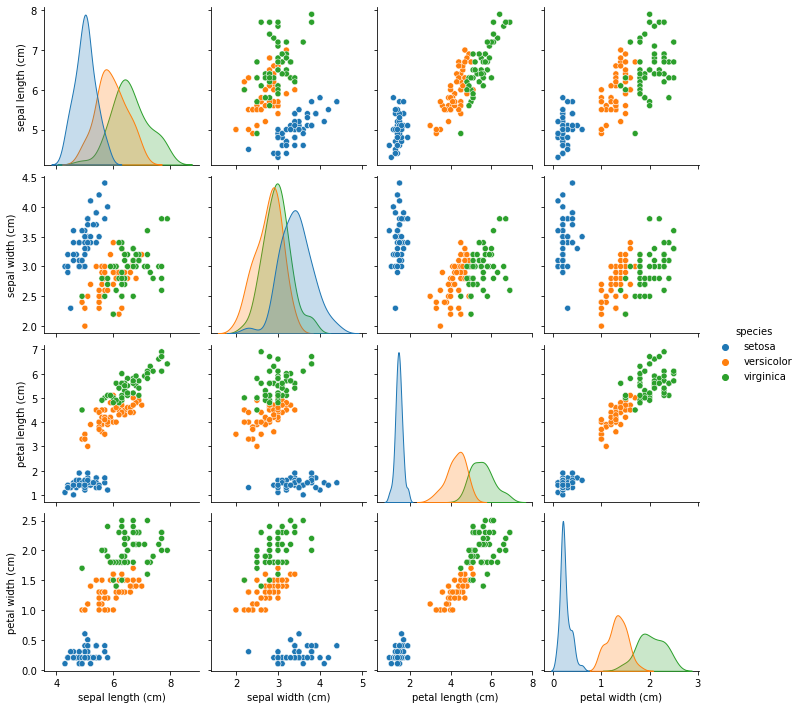

In [7]:
sns.pairplot(iris_dataframe, hue='species', vars=iris_dataframe.columns[:-2])

> 1. Take a look at the histograms for each feature (along the diagonal). Do you think the distribution of `sepal width` differs between species? How about `petal width`?

> 2. Now focus on the pair-plots. Can you find a combination of two features where you can completely separate the three species? Hint: Try to find a plot where you can draw three circles / ellipses such that each circle only contains points from one species. 

It looks like petal width and petal height are good at separating the three species of Iris flowers. We can concentrate on these two for now, also because using two features makes it easy to plot and visualize the results.

<AxesSubplot:xlabel='petal length (cm)', ylabel='petal width (cm)'>

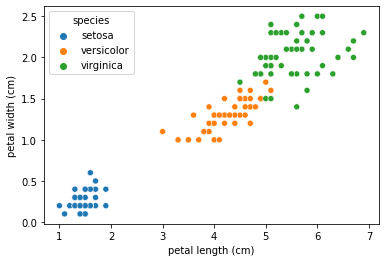

In [8]:
feature_names = ["petal length (cm)", "petal width (cm)"]
X = iris_dataframe[feature_names]
y = iris_dataframe["species_index"]
sns.scatterplot(x="petal length (cm)", y="petal width (cm)", hue="species", data=iris_dataframe)

**X** is a matrix with each data point as a row and each feature as a column. 

**y** is a list of 0s, 1s, and 2s, stating the species of each row in X. 

One important aspect in data science is the concept of training, validation, and testing. We typically want to use our classifiers on new data - new emails coming into your inbox, new handwriting from different people, new newspaper articles, and new Iris flower measurements. So, to make sure whatever patterns our classification algorithm learns will work on new data, we divide our existing dataset into a **train** and a **test** set. The algorithm is "trained" on the train set, meaning it uses this set to find patterns and learn how to distinguish between classes. And then "tested" or "validated" on the test set, meaning we compare the predictions it makes to the true classes and see how well it does. This is typically done by looking at a **confusion matrix**. In the case of a problem with two classes (which we'll refer to as class 0 and class 1), the confusion matrix looks something like this:

![Confusion matrix](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)
**True positives (TP)** are points which belong to class 0 and are correctly classified into class 0 by our classifier. **True negatives (TN)** are points that belong to class 1 and are correctly classified as class 1. **False positives (FP)** are class 1 points incorrectly labeled as class 0 by the classifier, and vice verse for **False negatives (FN)**. 

These terms are named this way as many classification problems are binary. For example, in spam prediction, a true positive would be a spam email correctly labeled as spam while a false positive would be a valid email from a friend or colleague incorrectly labeled as spam. As you may imagine, in this scenario, false positives are much worse than false negatives! In a different classification problem, such as predicting if a patient has a certain disease, while a false positive can be rectified with further tests, a false negative (predicting the patient doesn't have the disease while in fact they do) can be much more harmful.

These terms extend naturally to more than two classes, as below:

![Multiclass onfusion matrix](https://git.wageningenur.nl/durai001/data_science_crash_course/raw/master/classification/multiclass_confusion_matrix.png)

We'll use a helper function from the scikit-learn library to randomly divide our dataset into train and test sets. the `test_size` parameter below decides how many data points end up in the test set - in this case it's 20%. The plot shows the feature values of the train points (colored) and test points (white).

<AxesSubplot:xlabel='petal length (cm)', ylabel='petal width (cm)'>

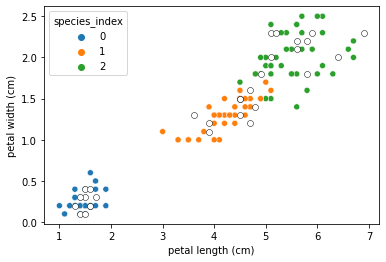

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
fig, ax = plt.subplots()
sns.scatterplot(x=X_train["petal length (cm)"], y=X_train["petal width (cm)"], hue=y_train, ax=ax)
sns.scatterplot(x=X_test["petal length (cm)"], y=X_test["petal width (cm)"], color="white", edgecolor="black", ax=ax, legend=False)

### The K-Nearest Neighbors Classifier

Let's start with one of the simplest classifiers - the K Nearest Neighbors classifier. As the name suggests, this classifier looks at the k nearest points to a given point, checks their classes, and uses a max vote strategy to decide the class of the given point.

> 3. Pick two test points in the plot above, and find their 5 nearest neighbors. What would the class of your chosen points be according to their nearest neighbors? Is this always correct?

Let's do this with a library now instead of by eye:

In [10]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

KNeighborsClassifier()

The `fit` function *trained* or classifier on the training data. We'll then use the `predict` function to see what classes it assigns to the test points:

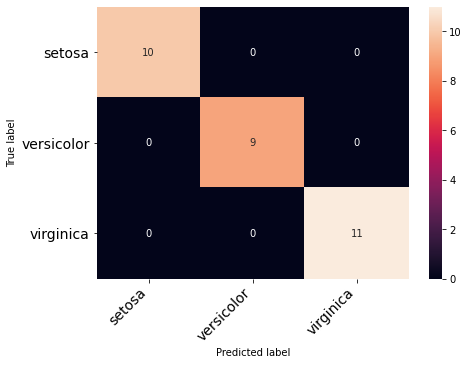

In [11]:
y_pred = clf.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test, y_pred), ["setosa", "versicolor", "virginica"])

> 4. Does this classifier perform well on the test set?

Since there's only two features we can plot one against the other and see what our classifier predicts at each combination of petal width and petal length:

C:\Users\selor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


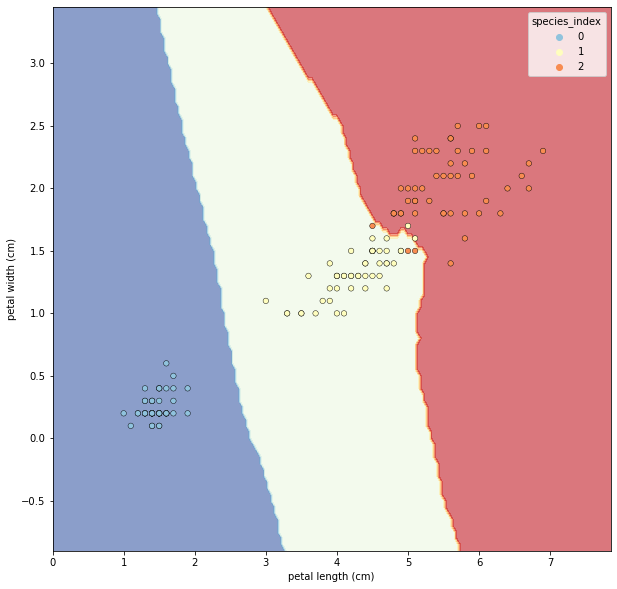

In [12]:
plot_decision_boundary(X, y, feature_names, clf)

> 5. What happens if you change the number of neighbors that the classifier looks at? (Change the `n_neighbors` value in the cell that makes the classifier and rerun the cells underneath)

### Decision Tree Classifier

While the K Nearest Neighbors Classifier seemed to perform very well on our Iris dataset, we were only able to see what it was doing because we were working with two features, so we could plot them. In general, most datasets will have many more than two features, making the nearest neighbors classifier a bit opaque as we can't say anything about what kinds of features correlate with a particular category. 

A more interpretable classifier is the decision tree. A decision tree is a flowchart-like structure where each node represents a certain split in the data based on one feature value. For example - one node could be the split represented by "petal_length < 2 cm" - this leads to two branches in the tree, the first containing points with `petal_length` < 2 cm and the second containing points with `petal_length` >= 2cm. The goal of the decision tree is to find feature splits that can distinguish between the different classes. 

> 6. Can you think of a feature split that differentiates setosa data points from versicolor?

In [13]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

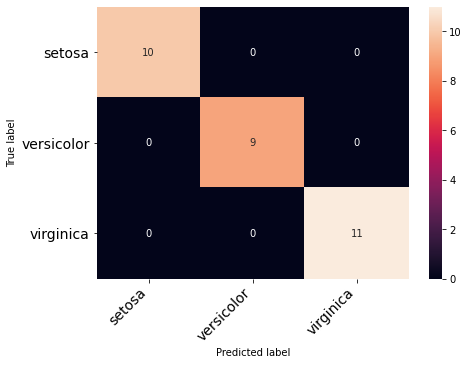

In [14]:
y_pred = clf.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test, y_pred), ["setosa", "versicolor", "virginica"])

C:\Users\selor\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


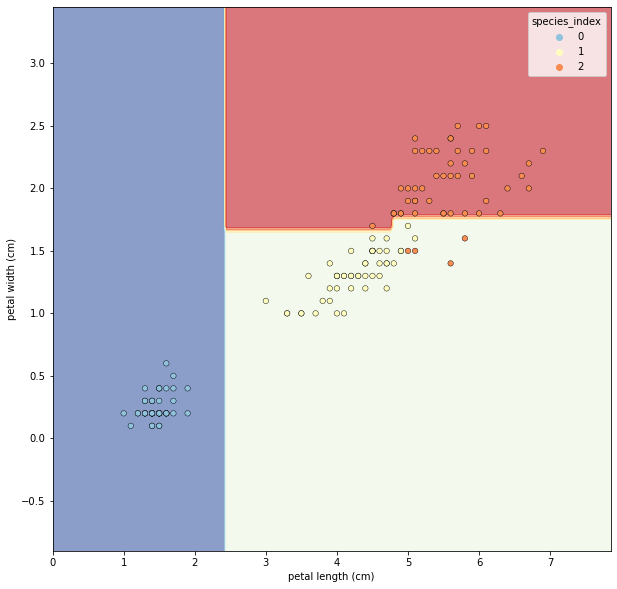

In [15]:
plot_decision_boundary(X, y, feature_names, clf)

As before, there's a pretty reasonable decision boundary between the three classes. One parameter of the decision tree is "max_depth", which represents the maximum allowed depth of the tree. A max_depth of 1 would mean the tree can have exactly one node with two branches coming out of it. While a max_depth of 2 would mean each of these two branches can also have a node with another two branches attached.

> 7. What is the maximum number of nodes for a tree of max_depth = 3?

But now, let's look at the tree itself.

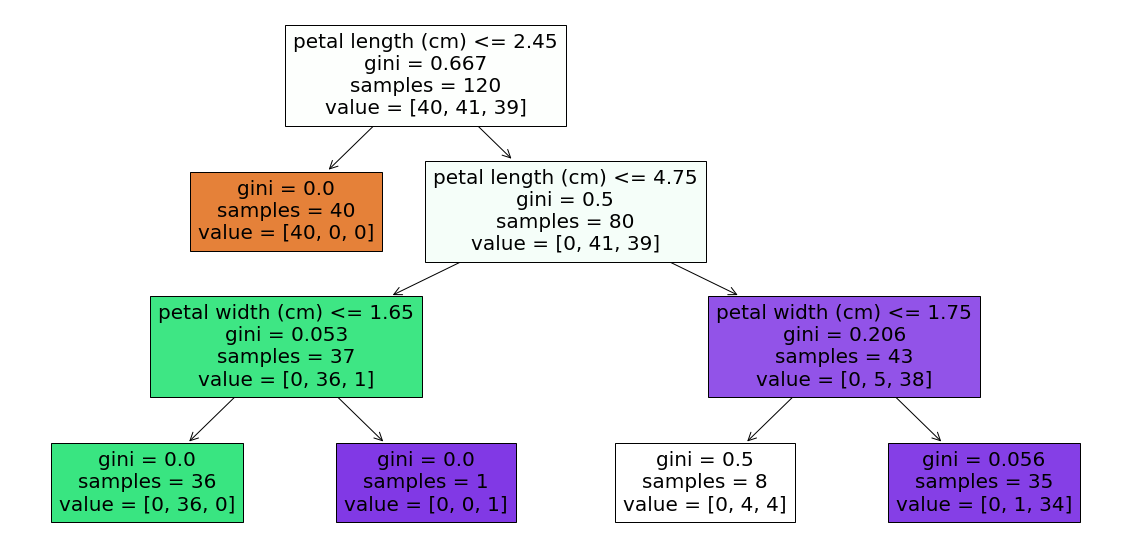

In [16]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, feature_names=feature_names);

Each node above is colored according to the majority class of the points inside it (i.e. an orange node has mostly points from class 0 (setosa), a green node has a lot of points from class 1 (versicolor), and a purple node has points from class 2 (virginica). The exact number of points in each class is written in the "value" part of the node. 

Each point is put through this flowchart-like decision process until it ends up at a leaf (a node with no branches). A well-trained decision tree would have "pure" leaves at the bottom of the tree, i.e. leaves with only one class of points in them.

> 8. Is this tree well-trained?

Experiment with increasing the `max_depth` value and rerunning the cells below it. 
> 9. What do you think of the shape of the decision boundary at max_depths of 2 and 5?
> 10. Does the tree grow in size when you increase the depth? Comment on its classification ability at different depths.

Algorithms like the decision tree which allows you to see which features are being used are very useful in scientific classification problems, as they can be used both to justify predictions (such as in medical settings) as well as design new experiments and confirm the importance of certain features.  

Already in this small dataset you can see that not all data points can be perfectly separated. Maybe adding another feature can help distinguish these cases better:

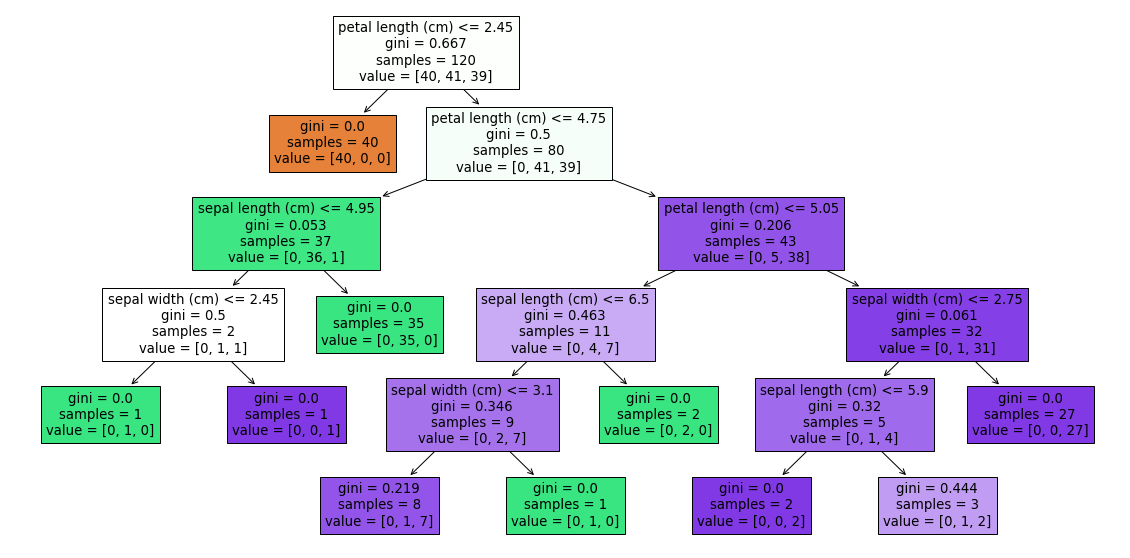

In [17]:
feature_names = ["petal length (cm)", "sepal length (cm)", "sepal width (cm)"]
X = iris_dataframe[feature_names]
y = iris_dataframe["species_index"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, feature_names=feature_names);

> 11. Would it be possible to plot the decision boundary for this classifier as we did in the questions above?

## Enzyme Dataset

Now we'll look at a bigger dataset, of terpene synthase enzymes - proteins in plants which form the chemical compounds which give plants their distinct fragrances. The smell of orange, pepper, mint, pine, grapes, and so on can all be traced back to these enzymes. And, though they make many hundreds of compounds (as you may imagine from the many plant smells you can remember), all of these derive from the same starting material or substrate. This substrate is captured in the active site of the enzyme with the help of some magnesium ions and certain motifs. It then undergoes a series of reactions to form one of the hundred possible compounds. 

![](https://git.wageningenur.nl/durai001/data_science_crash_course/raw/master/classification/tps_enzyme.png)

If we focus on just the first step in these reactions - all terpene synthase products derive from - the **farnesyl cation** or the **nerolidyl cation**, our two categories for classification.

In [18]:
enzyme_dataset = pd.read_csv("enzyme_dataset.csv")

In [19]:
enzyme_dataset

,Accession,Cation,Products,r_0,r_1,r_2,r_3,r_4,r_5,r_6,...,r_301,r_302,r_303,r_304,r_305,r_306,r_307,r_308,r_309,r_310
0,Q39980,farnesyl,vetispiradiene,L,R,F,A,K,L,D,...,Q,E,M,A,E,I,A,W,K,D
1,Q39979,farnesyl,vetispiradiene,-,-,-,-,-,-,-,...,Q,E,M,A,E,I,A,W,K,D
2,Q39978,farnesyl,vetispiradiene,L,R,F,A,K,L,D,...,Q,E,M,A,D,I,A,W,K,D
3,Q40577,farnesyl,(+)-5-epiaristolochene,L,R,F,A,K,L,D,...,Q,N,M,A,E,T,A,W,K,D
4,O48935,farnesyl,(E)-beta-farnesene,L,K,L,S,K,V,N,...,E,G,L,V,E,E,T,W,K,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,A0A1L1WP15,nerolidyl,"nerolidol,",-,E,L,A,K,M,D,...,T,Q,M,I,S,D,S,W,K,-
238,MK431785,nerolidyl,"cedrol,",-,R,L,A,T,L,N,...,A,E,I,I,E,D,A,W,K,D
239,A0A1W6GW32,farnesyl,"(-)-5-epieremophilene,",L,R,F,A,K,L,D,...,F,E,I,A,T,D,A,W,K,D
240,A0A1W6GW06,farnesyl,"(-)-5-epieremophilene,",L,K,F,A,K,L,D,...,F,E,I,A,T,D,A,W,K,D


The dataset consists of 242 enzymes, each labeled with the cation that they form. An enzyme can be defined by it's amino acid sequence with 311 residues (labeled r_0 to r_310 above). This sequence of amino acids corresponds to the 3D structure in the figure above, with a different sequence leading to slight changes in the corresponding structure.

There are 20 possible amino acids, labeled with different letters of the alphabet based on their names:

![](https://upload.wikimedia.org/wikipedia/commons/4/4f/Amino_Acids-wide.svg)

The dashes ('-') represent deletions, positions in the sequence which are present in other terpene synthase enzymes but not in this one. links back to structure

However, these letters are for humans. We can look at an L and figure out that it stands for the amino acid Leucine, and that an I stands for Isoleucine. We can then look at the chemical structures of these amino acids above and notice that they are very similar, and that both of them are quite different from the amino acid Histidine (H). The algorithm will not know this though. 

So, just as in the Iris dataset where we represented flowers by their petal and sepal dimensions, we will represent each amino acid in this sequence by some measured attribute of it. In this case we picked hydrophobicity - high values mean these amino acids don't like water so they usually end up buried inside the protein where water can't get at them, while low/negative values means these amino acids are attracted to water and may like the protein surface.  

In [20]:
hydrophobicity_scale = {
 'I': 4.5,
 'V': 4.2,
 'L': 3.8,
 'F': 2.8,
 'C': 2.5,
 'M': 1.9,
 'A': 1.8,
 '-': 0,
 'G': -0.4,
 'T': -0.7,
 'S': -0.8,
 'W': -0.9,
 'Y': -1.3,
 'P': -1.6,
 'H': -3.2,
 'E': -3.5,
 'Q': -3.5,
 'D': -3.5,
 'N': -3.5,
 'K': -3.9,
 'R': -4.5
 }

We replace each residue from its amino acid letter to its hydrophobicity value:

In [21]:
for index in range(311):
    enzyme_dataset[f"r_{index}"] = enzyme_dataset[f"r_{index}"].map(hydrophobicity_scale)

In [22]:
enzyme_dataset

,Accession,Cation,Products,r_0,r_1,r_2,r_3,r_4,r_5,r_6,...,r_301,r_302,r_303,r_304,r_305,r_306,r_307,r_308,r_309,r_310
0,Q39980,farnesyl,vetispiradiene,3.8,-4.5,2.8,1.8,-3.9,3.8,-3.5,...,-3.5,-3.5,1.9,1.8,-3.5,4.5,1.8,-0.9,-3.9,-3.5
1,Q39979,farnesyl,vetispiradiene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.5,-3.5,1.9,1.8,-3.5,4.5,1.8,-0.9,-3.9,-3.5
2,Q39978,farnesyl,vetispiradiene,3.8,-4.5,2.8,1.8,-3.9,3.8,-3.5,...,-3.5,-3.5,1.9,1.8,-3.5,4.5,1.8,-0.9,-3.9,-3.5
3,Q40577,farnesyl,(+)-5-epiaristolochene,3.8,-4.5,2.8,1.8,-3.9,3.8,-3.5,...,-3.5,-3.5,1.9,1.8,-3.5,-0.7,1.8,-0.9,-3.9,-3.5
4,O48935,farnesyl,(E)-beta-farnesene,3.8,-3.9,3.8,-0.8,-3.9,4.2,-3.5,...,-3.5,-0.4,3.8,4.2,-3.5,-3.5,-0.7,-0.9,-3.9,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,A0A1L1WP15,nerolidyl,"nerolidol,",0.0,-3.5,3.8,1.8,-3.9,1.9,-3.5,...,-0.7,-3.5,1.9,4.5,-0.8,-3.5,-0.8,-0.9,-3.9,0.0
238,MK431785,nerolidyl,"cedrol,",0.0,-4.5,3.8,1.8,-0.7,3.8,-3.5,...,1.8,-3.5,4.5,4.5,-3.5,-3.5,1.8,-0.9,-3.9,-3.5
239,A0A1W6GW32,farnesyl,"(-)-5-epieremophilene,",3.8,-4.5,2.8,1.8,-3.9,3.8,-3.5,...,2.8,-3.5,4.5,1.8,-0.7,-3.5,1.8,-0.9,-3.9,-3.5
240,A0A1W6GW06,farnesyl,"(-)-5-epieremophilene,",3.8,-3.9,2.8,1.8,-3.9,3.8,-3.5,...,2.8,-3.5,4.5,1.8,-0.7,-3.5,1.8,-0.9,-3.9,-3.5


Now we can use these as features for classification. We arbitrarily assign the farnesyl cation to class 0 and the nerolidyl cation to class 1.

In [23]:
X = enzyme_dataset[enzyme_dataset.columns[3:]]
y = [0 if c == "farnesyl" else 1 for c in enzyme_dataset["Cation"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

Since we have 311 features (one for each residue in every sequence) we can't rely on 2D visualization to see how the classifier is making a decision - so let's use the more interpretable decision tree algorithm.

In [24]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
clf.fit(X_train, y_train);

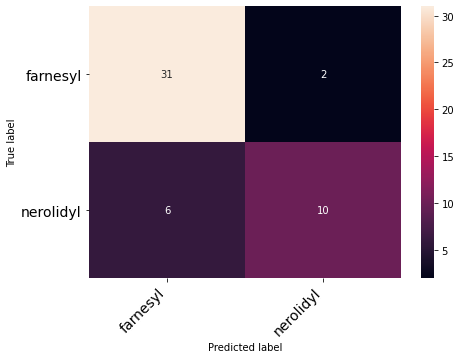

In [25]:
y_pred = clf.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test, y_pred), ["farnesyl", "nerolidyl"], fontsize=14)

> 12. What are the values of TP_farnesyl and TP_nerolidyl? 
> 13. What is the most common type of error made by the classifier?

Let's see which residues it's using for prediction:

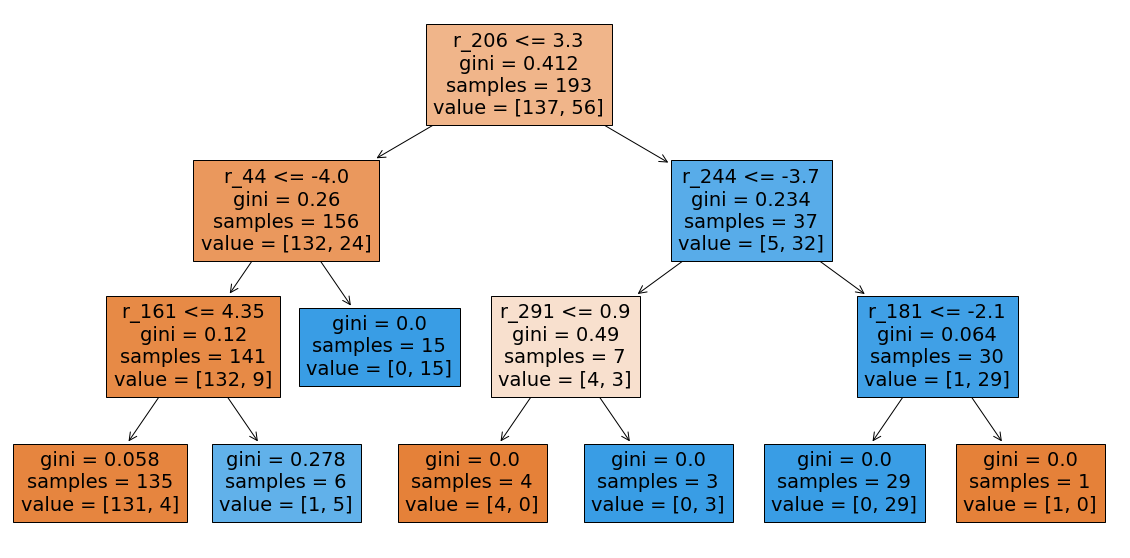

In [26]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, feature_names=enzyme_dataset.columns[4:]);

In [30]:
pip install prody

In [31]:
pip install py3Dmol


Note: you may need to restart the kernel to use updated packages.


> 14. How many residues are being used for classification?

You can use the information learnt by the classifier to understand more about the classification problem. For instance, we can take a look at the residues used for classification in the context of an enzyme structure and see if they make sense. 

The code in the next cell loads a terpene synthase structuree and maps our sequence indices to the structure indices. 

In [32]:
import prody
import py3Dmol

pdb = prody.parsePDB('5eau')
pdb_mapper = {}
j = 205
for i in range(311):
    if enzyme_dataset[enzyme_dataset['Accession'] == 'Q40577'][f"r_{i}"].values[0] == 0:
        continue
    pdb_mapper[i] = j
    j += 1
alpha_indices = [a.getIndex() for a in pdb.iterAtoms() if a.getName() == 'CA']

@> PDB file is found in working directory (5eau.pdb.gz).
@> 4405 atoms and 1 coordinate set(s) were parsed in 0.15s.


These are the residues that our decision tree is using for classification. If you play around with the decision tree and get a different set of residues, you can change them here and run the cell below to visualize them on the structure. The visualization is interactive, drag it around to see where the residues are in relation to the substrate.

In [33]:
residues = [206, 44, 134, 161, 184, 226]

In [34]:
view = prody.view3D(pdb, height=500, width=500)
view.setStyle({'cartoon':{'colorscheme':'gray'}})
motif_residues = list(range(243, 246)) + list(range(280, 286)) + list(range(423, 432))
view.setStyle({'resi': [f"{pdb[alpha_indices[r]].getResnum()}" for r in motif_residues]}, 
              {'cartoon':{'color':'blue'}})
view.setStyle({'resi': [f"{pdb[alpha_indices[pdb_mapper[r]]].getResnum()}" for r in residues if r in pdb_mapper]}, 
              {'cartoon':{'color':'red'}, 'stick': {'color': 'red'}})
view.setStyle({'hetflag':True},{'stick':{'color':'green'}})
view.setStyle({'resn':'MG'},{'sphere':{'color':'green'}})
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You may notice that many of the predictive residues, that our classifier thinks are important for classification, lie in the active site of the protein and face the substrate. The ones which lay further away may have something to do with protein folding and stability. These residues would now make good mutation targets for further experiments to understand more about these enzymes. 

# Random Forests (Optional)

A more complex classification algorithm is the Random Forest Classifier. Instead of a single decision tree, this classifier constructs many decision trees, each randomly trained with different subsets of the training data and different subsets of features. The predicted class for a test point is then the most common (max vote) class predicted by all the independent decision trees.

In [35]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=RANDOM_STATE)
clf.fit(X_train, y_train);

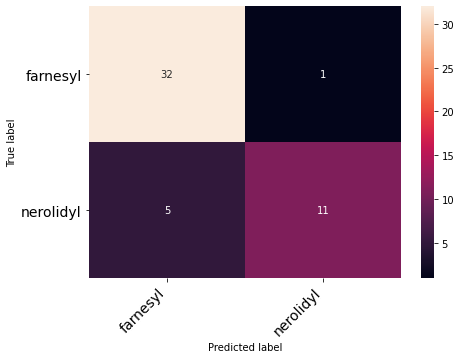

In [36]:
y_pred = clf.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test, y_pred), ["farnesyl", "nerolidyl"], fontsize=14)

> 15. Is this a better classifier for this dataset than the decision tree we made above?

In general, Random Forests are more powerful than Decision Trees as they are made up of multiple diverse trees in terms of both features and training points. Therefore, for large datasets with complex features, Random Forests (and other **ensemble** approaches which combine multiple classifiers) are often preferred over simpler approaches such as Decision Trees and Nearest Neighbors.

We do lose out a bit on the nice interpretability features of a single decision tree, but Random Forests are also interpretable to some extent. You can access each decision tree within the RandomForest with the `estimators_` attribute and plot them individually.

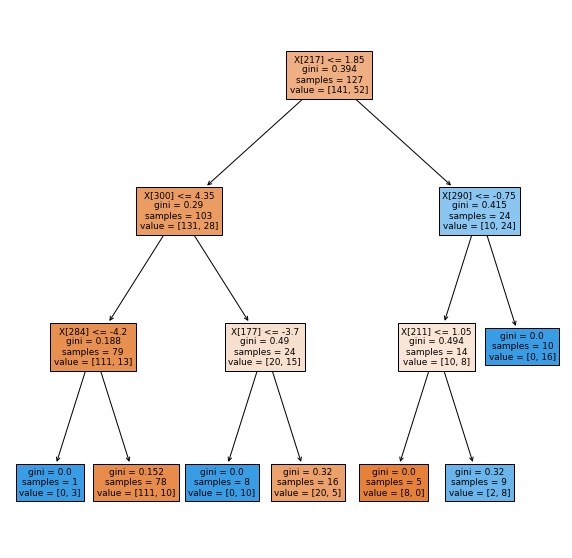

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(clf.estimators_[0], filled=True, ax=ax);

You can also look at the `feature_importances_` attribute which tells you how often a particular residue is used in each of the 10 decision trees. This gives an estimate of how predictive the residue is.

C:\Users\selor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

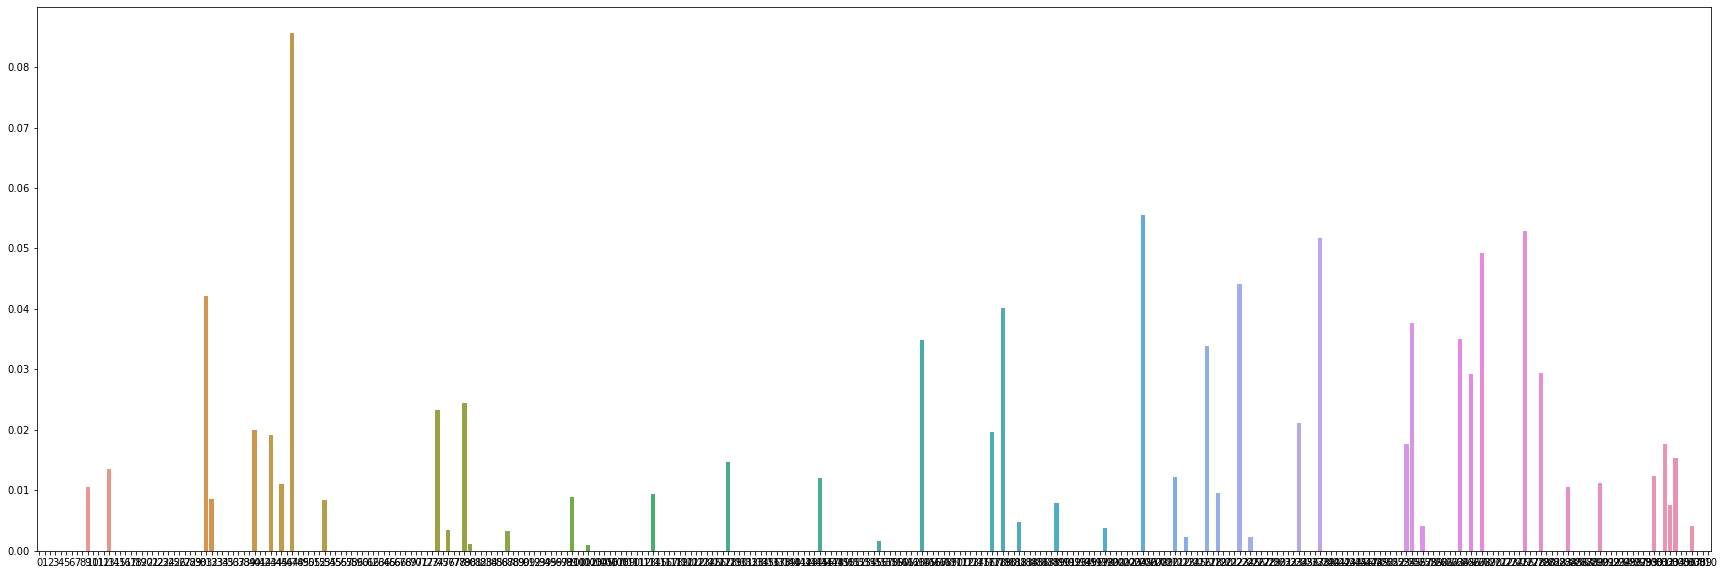

In [38]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(np.arange(0, 311), clf.feature_importances_, ax=ax)